LightGBMのパラメータをチューニングし、モデルを作成した

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import seaborn as sns
from seaborn_analyzer import regplot

import optuna.integration.lightgbm as lgb_tune

import time

import collections

import lightgbm as lgb
from lightgbm import LGBMRegressor

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [5]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [6]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [7]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [8]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [21]:
pd.reset_option('display.max_rows')

LightGBMでモデルを作成する

In [22]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

パラメータのチューニングをする

In [23]:
X_train, X_test, y_train, y_test = train_test_split(trainX, y, test_size=0.3)
dtrain = lgb.Dataset(X_train, y_train)
dval = lgb.Dataset(X_test,y_test)

LightGBM用のoptunaを導入

In [24]:
params = {
    "objective": "regression",
    "metrics": "mae"
}
best_params, tuning_history = dict(), list()
booster = lgb.train(params, dtrain, valid_sets=dval,
                    verbose_eval=0)
best_params = booster.params
print('Best Params:', best_params)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 67
[LightGBM] [Info] Start training from score 0.242453
Best Params: {'objective': 'regression', 'metrics': 'mae', 'num_iterations': 100, 'early_stopping_round': None}


C:\Users\GuestUser\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [25]:
model = lgb.train(best_params, dtrain, valid_sets=dval,
                    verbose_eval=0)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 67
[LightGBM] [Info] Start training from score 0.242453


C:\Users\GuestUser\anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [26]:
trainXpred = model.predict(trainX)
trainXpred = trainXpred.astype(object)
trainXl = len(trainXpred)

In [27]:
ansRateList = pd.DataFrame()
for j in range(25):
    c = trainXpred.copy()
    n = (38+j)/100
    for i in range(trainXl):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase = np.equal(c,y)
    ansRate = collections.Counter(ansRateBase)[True]/len(ansRateBase)
    ansRateData = pd.DataFrame([[n,ansRate]])
    ansRateList = pd.concat([ansRateList,ansRateData],ignore_index=True)
ansRateList

,0,1
0,0.38,0.884152
1,0.39,0.884828
2,0.40,0.886057
3,0.41,0.886671
4,0.42,0.887408
5,0.43,0.889128
6,0.44,0.888882
7,0.45,0.890172
8,0.46,0.890356
9,0.47,0.891278


([<matplotlib.axis.XTick at 0x24f4a80d7f0>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

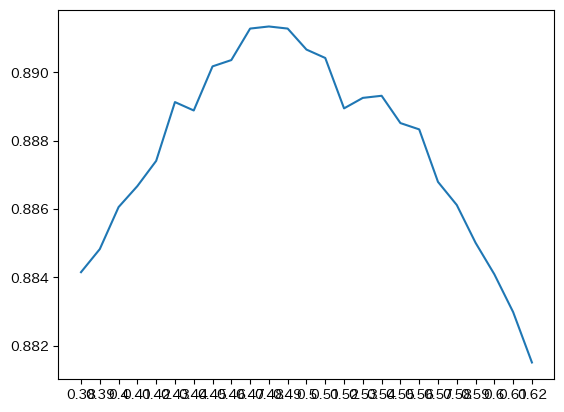

In [28]:
plt.plot(ansRateList[1])
plt.xticks(range(25),ansRateList[0])

予測に代入して結果を出力する

In [29]:
pred = model.predict(testX)

In [30]:
l = len(pred)

In [31]:
pred = pred.astype(object)
for i in range(l):
    if pred[i] <= 0.50:
        pred[i] = "<=50K"
    else:
        pred[i] = ">50K"

In [32]:
sample[1] = pred

In [33]:
sample.to_csv("submit7_8.csv",index=None,header=None)